# Проект e-learning

### Задачи проекта 
* Определить, сколько студентов успешно сдали только один курс
2. Определить курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. 
3. Определить по каждому предмету средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). 
4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 
5. Выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

6. Построить адаптированные RFM-кластеры студентов, чтобы качественно оценить аудиторию. В адаптированной кластеризации использовать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно описать процесс создания кластеров. Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.

### Загрузка данных для работы

Импортируем необходимые библиотеки для работы

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

запишем данные 4 дата-сетов для дальнейшей работы

In [2]:
assessments_df = pd.read_csv('../Between_Project/assessments.csv')
courses_df = pd.read_csv('../Between_Project/courses.csv')
studentAssessment_df = pd.read_csv('../Between_Project/studentAssessment.csv')
studentRegistration_df = pd.read_csv('../Between_Project/studentRegistration.csv')

Изучим, какие данные лежат в этих дата-сетах

In [3]:
#информация о тестах - 206 строковых записей, пропущенных значений нет 
assessments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [4]:
#список предметов по семестрам - 22 строковых записи, пропущенных значений нет 
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [5]:
#результаты тестов студентов - 173 912 записей, пропусков нет 
studentAssessment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [6]:
#информация о регистрации студентов - 32 593 записей, пропусков нет
studentRegistration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


##### определение курса

**ЧТО СЧИТАТЬ КУРСОМ?**

Возможные критерии курса, которые мы проверим: 

- Проверим по идентификаторам предмета и модуля, есть ли уникальные значения
- На курсе должны учиться студенты. Это можно проверить по регистрации студентов в studentRegistration_df с учетом оттока
- Курс должен завершаться аттестацией, в данных есть отдельная таблица об оценках тестов, где есть тип теста Exam, его окончательная сдача (количество дней от начала семестра). В таблице studentAssessment_df есть данные об оценках конкретных студентов, что они сдавали. Это поможет проверить, действительно ли студенты сдавали экзамены 



In [3]:
#уникальные сочетания по коду предмета и коду семестра 
code_course = courses_df.groupby(['code_module', 'code_presentation'], as_index=False) \
                            .agg({'module_presentation_length':'count'}) 
code_course.shape

(22, 3)

На данном этапе у нас есть 22 курса. Посмотрим, у каких курсов были экзамены 

In [5]:
#отберем записи, где тип контроля = Exam
assessments_courses_df = assessments_df.query("assessment_type == 'Exam'").reset_index().drop(columns=['index'])
assessments_courses_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1757,Exam,NaN,100.0
1,AAA,2014J,1763,Exam,NaN,100.0
2,BBB,2013B,14990,Exam,NaN,100.0
3,BBB,2013J,15002,Exam,NaN,100.0
4,BBB,2014B,15014,Exam,NaN,100.0


In [6]:
#считаем количество студентов по количеству дней сдачи = студент точно сдавал экзамен
id_assesment_stats = studentAssessment_df.groupby('id_assessment', as_index = 'False') \
                    .agg({'date_submitted':'count'}) \
                    .rename(columns={'date_submitted':'students'})
id_assesment_stats.head(3)

,students
id_assessment,
1752,359
1753,342
1754,331


In [7]:
#добавим полученные данные к данным экзамена 
exam_df = assessments_courses_df.merge(id_assesment_stats, how = 'left', on = 'id_assessment')
exam_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,students
0,AAA,2013J,1757,Exam,NaN,100.0,NaN
1,AAA,2014J,1763,Exam,NaN,100.0,NaN
2,BBB,2013B,14990,Exam,NaN,100.0,NaN
3,BBB,2013J,15002,Exam,NaN,100.0,NaN
4,BBB,2014B,15014,Exam,NaN,100.0,NaN


In [10]:
#оставим только те курсы, где студенты сдавали экзамен
courses_list = exam_df.query("students.notna()").drop(columns=['weight']).reset_index(drop=True)
courses_list

,code_module,code_presentation,id_assessment,assessment_type,date,students
0,CCC,2014B,24290,Exam,NaN,747.0
1,CCC,2014J,24299,Exam,NaN,1168.0
2,DDD,2013B,25340,Exam,240.0,602.0
3,DDD,2013J,25354,Exam,261.0,968.0
4,DDD,2014B,25361,Exam,241.0,524.0
5,DDD,2014J,25368,Exam,NaN,950.0


У нас получилась таблица с 6 курсами, у которых есть уникальная комбинация кода предмета и кода модуля, экзамен как форма контроля и сдававшие этот экзамен студенты

**курсом будет считать отдельный предмет в отдельном модуле, где студенты сдавали экзамен**



### Задача 1. Определить, сколько студентов успешно сдали только один курс
нужны данные studentAssessment - id теста, id студента и оценка за курс
и данные courses_list - id теста

1. Посмотреть, сколько экзаменов сдавал каждый студент
2. Если у студента 2 и более экзамена, то не включать в общее количество тех студентов, у кого больше 1 успешной сдачи или оба экзамена не сданы


In [12]:
#сколько курсов сдавал каждый студент - создадим отдельную колонку  
students_test = courses_list.merge(studentAssessment_df, how='left', on='id_assessment')
# Группируем по id_student и считаем количество оценок
number_of_tests = students_test.groupby('id_student')['id_assessment'].count().reset_index()
# Переименовываем столбец
number_of_tests = number_of_tests.rename(columns={'id_assessment': 'number_test'})
# Объединяем с students_test, чтобы добавить новую колонку
students_test = students_test.merge(number_of_tests, how='left', on='id_student')

In [13]:
#есть студенты, у кого больше 1 экзамена
students_test.head()

,code_module,code_presentation,id_assessment,assessment_type,date,students,id_student,date_submitted,is_banked,score,number_test
0,CCC,2014B,24290,Exam,NaN,747.0,558914,230,0,32.0,2
1,CCC,2014B,24290,Exam,NaN,747.0,559706,234,0,78.0,2
2,CCC,2014B,24290,Exam,NaN,747.0,559770,230,0,54.0,1
3,CCC,2014B,24290,Exam,NaN,747.0,560114,230,0,64.0,2
4,CCC,2014B,24290,Exam,NaN,747.0,560311,234,0,100.0,2


In [14]:
#создадим сводную таблицу, где id студента будет индексом, экзамен колонками, а баллы их значением
test_pivot = students_test.pivot(index='id_student', columns=['code_module', 'code_presentation'], values='score')
test_pivot.head()

code_module         CCC         DDD                  
code_presentation 2014B 2014J 2013B 2013J 2014B 2014J
id_student                                           
23698               NaN  80.0   NaN   NaN   NaN   NaN
24213               NaN   NaN   NaN   NaN  58.0   NaN
27116               NaN  96.0   NaN   NaN   NaN   NaN
28046               NaN   NaN   NaN  40.0   NaN   NaN
28787               NaN  44.0   NaN   NaN   NaN   NaN

In [16]:
#какие значения больше 39 и сколько их = сколько студентов успешно сдали только 1 тест 
value = test_pivot.gt(39).sum(axis=1)
value[value == 1].sum()

3802

#### Результат - 3 802 студента успешно сдали только один экзамен

### Задача 2. Определить курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [15]:
#отберем тех студентов, у которых были экзамены по 6 курсам из courses_list
students_score = studentAssessment_df.merge(courses_list, how = 'inner', on = 'id_assessment')
students_score.head(3)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,students
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,747.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,747.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,747.0


In [16]:
#проверим, есть ли студенты с перезачетами с прошлого года 
students_score.groupby('is_banked', as_index = False) \
                 .agg({'id_student':'count'})

,is_banked,id_student
0,0,4959


In [17]:
#сделаем score бинарной переменной, где значение 40 и больше - успешная сдача, меньше 40 - неуспешная сдача
# 0 это успешная сдача, 1 неуспешная
def coding_value(x):
    if x >= 40:
        return 0
    if x < 40:
        return 1
    return 'NaN'

# закодируем данные и создадим новый столбец coded_score
students_score['coded_score'] =students_score['score'].apply(coding_value)
students_score.head(3)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,students,coded_score
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,747.0,1
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,747.0,0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,747.0,0


In [18]:
#сколько было успешных сдач экзамена
success_score = students_score.query("coded_score == 0") \
                 .groupby(['code_module', 'code_presentation','id_assessment'], as_index=False) \
                 .agg({'score':'count'}) \
                 .rename(columns={'score':'success_exam'})
#сколько всего было сдач экзамена
all_score = students_score.groupby(['code_module', 'code_presentation','id_assessment'], as_index=False) \
                 .agg({'score':'count'}) \
                 .rename(columns={'score':'all_exam'})

#какая доля студентов успешно сдала экзамен в каждом курсе 
# Объединение результатов
result = pd.merge(success_score, all_score, on=['code_module', 'code_presentation', 'id_assessment'])
# Вычисление доли успешных сдач
result['success_rate'] = round(result['success_exam'] / result['all_exam'] * 100, 2)

result

,code_module,code_presentation,id_assessment,success_exam,all_exam,success_rate
0,CCC,2014B,24290,664,747,88.89
1,CCC,2014J,24299,1019,1168,87.24
2,DDD,2013B,25340,504,602,83.72
3,DDD,2013J,25354,878,968,90.70
4,DDD,2014B,25361,485,524,92.56
5,DDD,2014J,25368,842,950,88.63


Курс с **самой высокой завершаемостью** 92.56% - предмет DDD в модуле 2014B, где экзамен имеет код теста 25361

Курс с **самой низкой завершаемостью** 83.72% - предмет DDD в модуле 2013B (изначальная кодировка в данных assessments.csv) где экзамен имеет код теста 25340	 	

### Задача 3. Определить по каждому предмету средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).


In [19]:
#отберем студентов, которые сдавали экзамены по предметам (code_module)
courses_df = assessments_df.query("assessment_type == 'Exam'").reset_index().drop(columns=['index'])
students_exam = courses_df.merge(studentAssessment_df, how = 'inner', on = 'id_assessment')
students_exam.head(3)

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,CCC,2014B,24290,Exam,NaN,100.0,558914,230,0,32.0
1,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
2,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0


In [20]:
#оставим студентов, у которых нет перезачете по предмету с прошлого года 
students_exam = students_exam.query('is_banked == 0') 

In [21]:
#какие типы данных --> переведем score в тип int64
students_exam.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
id_student             int64
date_submitted         int64
is_banked              int64
score                float64
dtype: object

In [22]:
students_exam['score'] = students_exam['score'].astype('int64')

In [23]:
#отберем те записи, где score выше 39 и date_submitted максимальная 
students_exam_unbanked = students_exam.query('score > 39')
students_exam_max = students_exam_unbanked.groupby(['id_student', 'code_module'], as_index=False) \
                      .agg({'date_submitted':'max'})

In [24]:
#группировка по курсу и выведем среднее по дате сдачи 
students_exam_mean = students_exam_max.groupby('code_module', as_index = False) \
                  .agg({'date_submitted':'mean'}).round(1) \
                  .rename(columns={'date_submitted':'mean_date'})
students_exam_mean

,code_module,mean_date
0,CCC,239.3
1,DDD,238.0


### Средний срок сдачи студентами экзамена по каждому предмету (дней от начала предмета):

1. ССС в среднем 239.3 дней от начала предмета
2. DDD в среднем 238 дней от начала предмета


### Задача 4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 
будем использовать датасет studentRegistration_df 

В этой задаче будем рассматривать все предметы, не только с экзаменами. Для расчета процента оттока будем учитывать только студентов без повторной регистрации на тот же предмет

In [25]:
#посмотрим на пропуски -- в колонке date_unregistration пропуски означают, что студенты не отменяли свою регистрацию 
student_registration = studentRegistration_df
student_registration.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

Посмотрим на пропущенные данные в столбце Дата регистрации.Если также будут пропущены значения у столбца Дата отмены регистрации, то мы исключим такие данные. Мы не можем их оставить, так как нам неизвестно, был ли студент в итоге зарегистрирован и что обозначает данный NaN - пропуск значения или то, что студент закончил курс.

Если есть отметка о дате отмены регистрации, то мы учитываем данные значения для подсчета регистраций и оттока.

In [26]:
# есть ли записи, где одновременно пропущены значения в date_registration и date_unregistration 
drop_registrate = student_registration.query("date_registration == 'NaN' & date_unregistration == 'NaN'").index
drop_registrate

Int64Index([2344, 12893, 14392, 14393, 17559, 23796], dtype='int64')

In [27]:
# всего 6 записей, удовлетворяющих данное условие. Их мы исключим из анализа
student_registration = student_registration.drop(drop_registrate)

In [28]:
# в колонке date_registration перекодируем значения NaN в 99999, чтобы эти значения не были потеряны при подсчете студентов
student_registration['date_registration'].fillna(99999, inplace=True)

In [29]:
#теперь посмотрим,сколько студентов регистрировалось на каждый предмет
registrate = student_registration.groupby('code_module', as_index=False) \
                        .agg({'id_student':'nunique'}) \
                        .rename(columns={'id_student':'registration'}) \
                        .sort_values('registration', ascending=False)
unregistrate = student_registration.groupby('code_module', as_index=False) \
                        .agg({'date_unregistration':'nunique'}) \
                        .rename(columns={'date_unregistration':'unregistration'}) \
                        .sort_values('unregistration', ascending=False)

In [30]:
#объединим в общую статистику регистраций на курс и посчитаем процент оттока
registration_full = registrate.merge(unregistrate, how = 'inner', on = 'code_module')
registration_full['churn_perc'] = (registration_full['unregistration'] / registration_full['registration'] * 100).round(2)
registration_full

,code_module,registration,unregistration,churn_perc
0,BBB,7691,337,4.38
1,FFF,7396,338,4.57
2,DDD,5846,339,5.80
3,CCC,4250,333,7.84
4,EEE,2859,234,8.18
5,GGG,2525,165,6.53
6,AAA,712,98,13.76


In [31]:
#выведем ТОП-3 предмета по количеству регистраций
registration_full.sort_values('registration', ascending=False).head(3)

,code_module,registration,unregistration,churn_perc
0,BBB,7691,337,4.38
1,FFF,7396,338,4.57
2,DDD,5846,339,5.80


In [32]:
#выведем ТОП-3 предмета по оттоку
registration_full.sort_values('churn_perc', ascending=False).head(3)

,code_module,registration,unregistration,churn_perc
6,AAA,712,98,13.76
4,EEE,2859,234,8.18
3,CCC,4250,333,7.84


### Самыми популярными предметами по количеству регистраций оказались:
1. BBB  - 7 691 зарегистрировавшихся студентов
2. FFF  - 7 396 зарегистрировавшихся студентов
3. DDD  - 5 846 зарегистрировавшихся студентов

### Лидерами по оттоку оказались следующие предметы: 
1. AAA - 13.8% студентов отменили свою регистрацию. 
2. EEE - 8.2% студентов отменили регистрацию на предмет. 
3. CCC - 7.8% студентов отмении свою регистрацию.

### Задача 5. Выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов


In [33]:
#Так как у нас уже была подсчитана завершаемость курса во 2 задании, мы обратимся к этим данным
result

,code_module,code_presentation,id_assessment,success_exam,all_exam,success_rate
0,CCC,2014B,24290,664,747,88.89
1,CCC,2014J,24299,1019,1168,87.24
2,DDD,2013B,25340,504,602,83.72
3,DDD,2013J,25354,878,968,90.70
4,DDD,2014B,25361,485,524,92.56
5,DDD,2014J,25368,842,950,88.63


In [34]:
#добавим данные по модулю из таблицы
Semester_info = result.merge(assessments_df, how = 'inner', on = 'id_assessment')
#уберем лишние столбцы 
Semester_info = Semester_info.drop(columns=['code_module_x', 'code_presentation_x', 'code_module_y','assessment_type', 'date','weight'])
Semester_info

,id_assessment,success_exam,all_exam,success_rate,code_presentation_y
0,24290,664,747,88.89,2014B
1,24299,1019,1168,87.24,2014J
2,25340,504,602,83.72,2013B
3,25354,878,968,90.70,2013J
4,25361,485,524,92.56,2014B
5,25368,842,950,88.63,2014J


In [35]:
#посчитаем успешность каждого модуля
complation_course = Semester_info.groupby('code_presentation_y', as_index=False) \
             .agg({'success_exam':'sum', 'all_exam':'sum'}) \
             .rename(columns={'code_presentation_y':'code_presentation'})
complation_course['complation'] = (complation_course['success_exam'] / complation_course['all_exam'] * 100).round(2)
complation_course

,code_presentation,success_exam,all_exam,complation
0,2013B,504,602,83.72
1,2013J,878,968,90.70
2,2014B,1149,1271,90.40
3,2014J,1861,2118,87.87


In [36]:
#средняя продолжительность сдачи экзаменов по курсу была рассчитана в 3 задаче
#используем промежуточному датафрейму,где данные по студентам отобраны, но без подсчета средней продолжительности
students_count = students_exam_unbanked.groupby(['id_assessment','id_student', 'code_presentation'], as_index=False) \
                      .agg({'date_submitted':'max'})
students_count.head(3)

,id_assessment,id_student,code_presentation,date_submitted
0,24290,29764,2014B,230
1,24290,29820,2014B,230
2,24290,40604,2014B,234


In [37]:
#добавим информацию по семестру
date_exam = students_count.merge(Semester_info, how='inner', on = 'id_assessment')
date_exam.head(3)

,id_assessment,id_student,code_presentation,date_submitted,success_exam,all_exam,success_rate,code_presentation_y
0,24290,29764,2014B,230,664,747,88.89,2014B
1,24290,29820,2014B,230,664,747,88.89,2014B
2,24290,40604,2014B,234,664,747,88.89,2014B


In [38]:
#посчитаем средний срок сдачи в каждом модуле
mean_exam = date_exam.groupby('code_presentation', as_index=False) \
          .agg({'date_submitted':'mean'}) \
          .rename(columns={'date_submitted':'mean_date'}) \
          .round(2) \
          .sort_values('mean_date',ascending=False)
mean_exam

,code_presentation,mean_date
3,2014J,243.68
1,2013J,239.51
2,2014B,233.00
0,2013B,230.16


In [39]:
#объединим две таблицы для презентации 
courses_info = mean_exam.merge(complation_course, how = 'inner', on = 'code_presentation')
courses_info = courses_info.drop(columns=['success_exam', 'all_exam'])
courses_info

,code_presentation,mean_date,complation
0,2014J,243.68,87.87
1,2013J,239.51,90.70
2,2014B,233.00,90.40
3,2013B,230.16,83.72


### Семестр с самой низкой завершаемостью курсов - 2013B. 
Только 83.72% студентов завершили свои курсы в данном семестре. Предположительно, это можно объяснить высокой трудозатратностью курсов, низкой мотивацией студентов завершать обучение, сложный экзамен

### Семестр с самыми долгими средними сроками сдачи курсов - 2014J. 
В среднем студенту требуется 243.68 дней, чтобы сдать экзамен с начала семестра 

## Задача 6. Построить адаптированные RFM-кластеры студентов, чтобы качественно оценить аудиторию. 

В адаптированной кластеризации использовать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно описать процесс создания кластеров. Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Среднее время сдачи одного экзамена

In [40]:
#нам нужны студенты без перезачета с прошлого года и с последней датой сдачи экзамена
Students_df = studentAssessment_df.query('is_banked == 0')
#нам нужны данные студентов, которые сдавали экзамен по курсу
Students_df = Students_df.merge(courses_list, how='inner', on = 'id_assessment')
#добавим среднее значение по сдачи курса и среднее количество баллов для студентов
Student_RFM = Students_df.groupby(['id_student','id_assessment'], as_index=False) \
                         .agg({'date_submitted':'mean', 'score':'mean'}) \
                         .rename(columns={'date_submitted':'R', 'score':'M'}).round(2)

Student_RFM.head(3)

,id_student,id_assessment,R,M
0,23698,24299,243,80.0
1,24213,25361,236,58.0
2,27116,24299,243,96.0


In [41]:
#добавим завершаемость курсов студентами 
#количество всех попыток сдать экзамен
all_pass = Students_df.groupby('id_student', as_index=False) \
           .agg({'score':'count'}) \
           .rename(columns={'score':'all_pass'})
#количество успешных попыток
success_pass = Students_df.query('score > 39') \
           .groupby('id_student', as_index=False) \
           .agg({'score':'count'}) \
           .rename(columns={'score':'success_pass'})
#завершаемость курса у студента. 1 - успешно сдан 1 экзамен, 0.5 - успешно сдан только 1 экзамен
student_pass = success_pass.merge(all_pass, how = 'inner', on ='id_student')
student_pass['completeness'] = student_pass['success_pass'] / student_pass['all_pass']

student_pass.head(3)

,id_student,success_pass,all_pass,completeness
0,23698,1,1,1.0
1,24213,1,1,1.0
2,27116,1,1,1.0


In [42]:
student_pass['completeness'].unique()

array([1. , 0.5])

In [43]:
#объединим две таблицы для дальнейшего анализа
RFM = Student_RFM.merge(student_pass, how='left', on='id_student').drop(columns=['id_assessment', 'success_pass', 'all_pass'])
RFM.rename(columns={'completeness':'F'}, inplace=True)
RFM.head(3)

,id_student,R,M,F
0,23698,243,80.0,1.0
1,24213,236,58.0,1.0
2,27116,243,96.0,1.0


In [44]:
RFM.F.unique()

array([1. , nan, 0.5])

 Построим границы метрик recency, frequency и monetary

метрику R - среднее время сдачи одного экзамена можно разделить на 3 кластера:
1. 234 дня и меньше - раннее время сдачи экзамена - 1
2. от 235 до 242 дней - среднее время сдачи экзамена - 2
3. 243 дня и больше - позднее время сдачи экзамена - 3

In [45]:
RFM['R'].describe()

count    4959.000000
mean      238.483565
std         5.717577
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       285.000000
Name: R, dtype: float64

In [46]:
#закодируем данные переменной в соответствии с нашей разбивкой 
def R_CODING(x):
    if x <= 234:
        return 1
    if x > 234 and x <= 242:
        return 2
    else:
        return 3

RFM['R_score'] = RFM['R'].apply(R_CODING)
RFM['R_score'].unique()

array([3, 2, 1])

Метрика F - завершаемость курсов уже содержит три значения, которые означают принадлежность к определенной группе, мы перекодируем их в целые положительные значения
1. NaN - студент не завершил курс - 1
2. 0.5 - студент завершил только 1 курс - 2
3. 1 - студент завершил все курсы - 3

In [47]:
#закодируем данные переменной в соответствии с нашей разбивкой 
def F_CODING(x):
    if x == 1:
        return 3
    if x == 0.5:
        return 2
    else:
        return 1
RFM['F_score'] = RFM['F'].apply(F_CODING)
RFM['F_score'].unique()

array([3, 1, 2])

Метрика M - среднее количество баллов, получаемое за экзаменх разбита на 4 кластера - Не сдан, Сдан удовлетворительно, Сдан хорошо, Сдан отлично. Не сдан считается та оценка, которая меньше 40 баллов, остальные группы имеют шаг в 20 баллов (Сдан удовлетворительно) и шаг в 19 баллов (Сдан хорошо, Сдан отлично)
1. 39 баллов и меньше - экзамен не сдан - 2
2. От 40 баллов до 60 баллов - экзамен сдан удовлетворительно - 3
3. От 61 балла до 80 баллов - экзамен сдан хорошо - 4
4. От 81 балла до 100 баллов - экзамен сдан отлично - 5

In [48]:
RFM['M'].describe()

count    4959.000000
mean       65.572898
std        20.579186
min         0.000000
25%        51.000000
50%        67.000000
75%        82.000000
max       100.000000
Name: M, dtype: float64

In [49]:
#закодируем данные переменной в соответствии с нашей разбивкой 
def M_CODING(x):
    if x <= 39:
        return 2
    if x > 39 and x <= 60:
        return 3
    if x > 60 and x <= 80:
        return 4
    else:
        return 5
    
RFM['M_score'] = RFM['M'].apply(M_CODING)
RFM['M_score'].unique()

array([4, 3, 5, 2])

Получаем сегменты на основе RFM-оценки
Для этого объединяем значения R-score, F-score и M-score

In [50]:
RFM['RFM_Score'] = RFM['R_score'].map(str) + RFM['F_score'].map(str) + RFM['M_score'].map(str)
RFM.head(3)

,id_student,R,M,F,R_score,F_score,M_score,RFM_Score
0,23698,243,80.0,1.0,3,3,4,334
1,24213,236,58.0,1.0,2,3,3,233
2,27116,243,96.0,1.0,3,3,5,335


In [51]:
#посмотрим, сколько сегментов у нас получилось и сколько в каждом сегменте студентов
RFM_segment = RFM.groupby('RFM_Score', as_index=False) \
   .agg({'id_student':'count'}) \
   .rename(columns={'id_student':'quantity_students'}) \
   .sort_values('quantity_students', ascending=False).reset_index() \
   .drop(columns=['index']) \
   .assign(perc_students = lambda x: x['quantity_students'] / x['quantity_students'].sum() * 100).round(2)

In [52]:
RFM_segment

,RFM_Score,quantity_students,perc_students
0,234,575,11.60
1,335,537,10.83
2,333,520,10.49
3,133,502,10.12
4,334,492,9.92
5,134,482,9.72
6,233,474,9.56
7,135,410,8.27
8,235,372,7.50
9,312,198,3.99


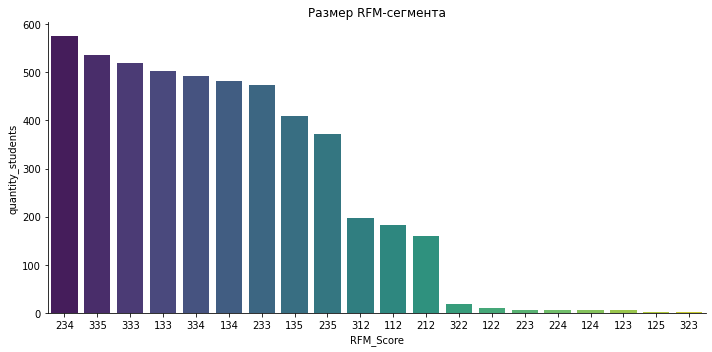

In [53]:
#визуальное представление размера сегмента RFM
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data=RFM_segment, x='RFM_Score', y='quantity_students', palette="viridis")
sns.despine()
ax.set_title('Размер RFM-сегмента', fontsize = 12)
plt.tight_layout()

У нас получилось 20 сегментов, из которых 8 достаточно малочисленных, менее 1% от общего количества студентов. Попробуем на основе перекрестных таблиц посмотреть, можно ли выделить более крупные кластеры из 20 сегментов


In [54]:
#создаем перекрестную таблицу по завершенности курса и средней оценке
ct = pd.crosstab(RFM['F_score'], RFM['M_score'])

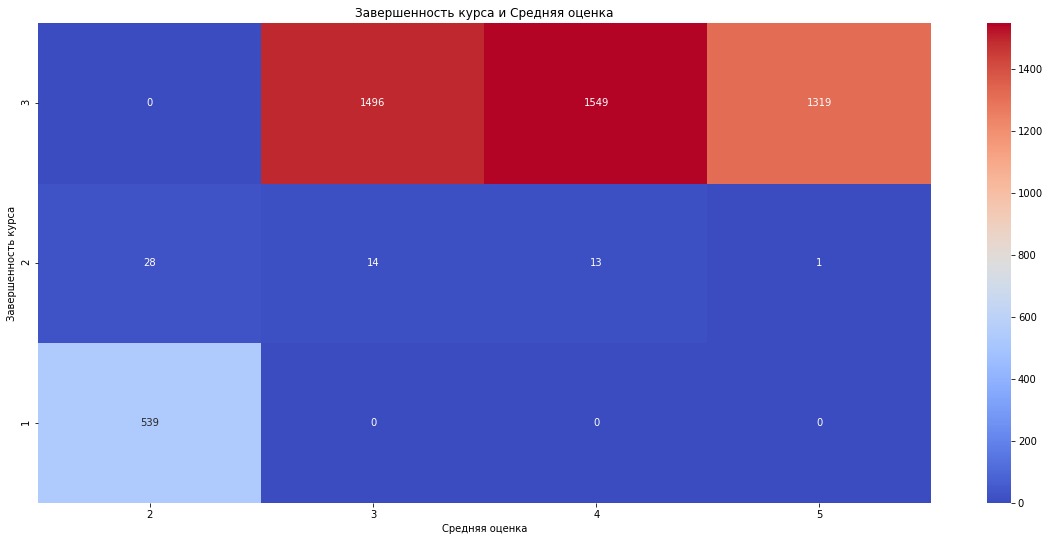

In [101]:
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(ct, cmap='coolwarm', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Завершенность курса')
ax1.set_xlabel('Средняя оценка')
ax1.set_title('Завершенность курса и Средняя оценка')
plt.show()

Перекрестная таблица по завершенности курса и средней оценке при визуализации показала 4 кластера. Проверим, что показывают перекрестные таблицы по завершенности курса и среднем времени сдачи экзамена, средней оценки и средним временем сдачи экзамена

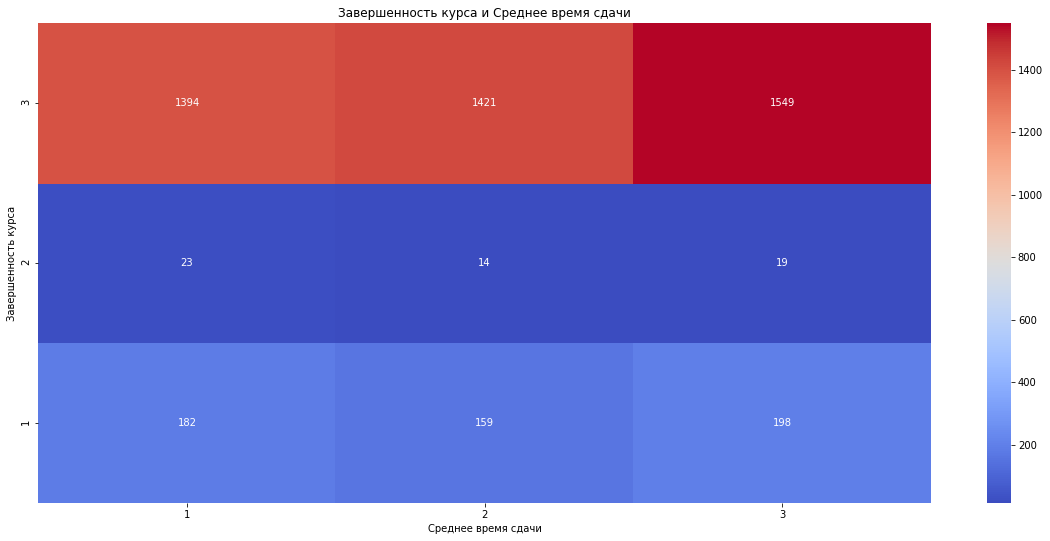

In [78]:
#создаем перекрестную таблицу по завершенности курса и среднем времени сдачи экзамена
ct2 = pd.crosstab(RFM['F_score'], RFM['R_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax2 = sns.heatmap(ct2, cmap='coolwarm', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Завершенность курса')
ax2.set_xlabel('Среднее время сдачи')
ax2.set_title('Завершенность курса и Среднее время сдачи')
plt.show()

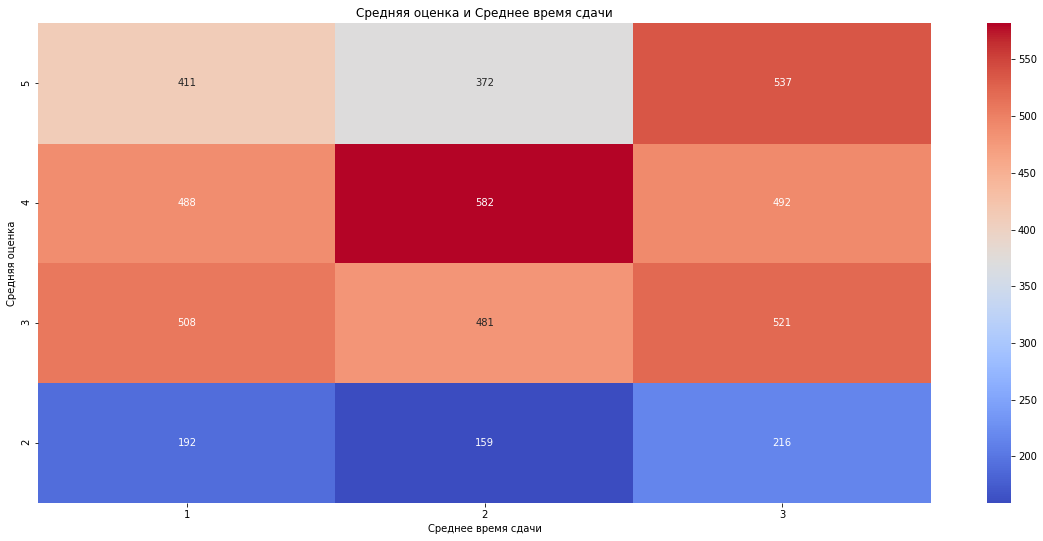

In [79]:
#создаем перекрестную таблицу по средней оценке и среднему времени
ct3 = pd.crosstab(RFM['M_score'], RFM['R_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax3 = sns.heatmap(ct3, cmap='coolwarm', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Средняя оценка')
ax3.set_xlabel('Среднее время сдачи')
ax3.set_title('Средняя оценка и Среднее время сдачи')
plt.show()

Мы выделим кластеры на основе метрик средней оценки и завершенности курса. Метрики среднее время сдачи и средняя оценка показывают 9 кластеров, без разграничений друг от друга (на тепловой карте они находятся примерно в одном цветовом спектре и примерно одинаковое количество студентов в каждом кластере)

1. **'Провалившиеся'** /Failure 
   в этом кластере находятся студенты, которые не завершили курс и не смогли сдать экзамен
2. **'Отстающие'** /Satisfactory 
   в этом кластере находятся студенты, которые завершили свой курс и сдали экзамен в диапозоне 40-60 баллов  
3. **'Хорошисты'** /Good 
   в этом кластере находятся студенты, которые завершили свои курсы и сдали экзамен в диапозоне 61-80 баллов
4. **'Отличники'** /Great 
   в этом кластере находятся студенты, которые завершили свои курсы и сдали экзамен в диапозоне 81-100 баллов
5. **'Пересдающие'** /Retake
   в этом кластере находятся студенты, у которых только 1 экзамен из 2 сдан успешно

In [102]:

segt_map = {
    r'[1-2]2': 'Failure', 
    r'33': 'Satisfactory',
    r'34': 'Good', 
    r'35': 'Great',
    r'2[3-5]': 'Retake'
}
RFM['Segment'] = RFM['F_score'].map(str) + RFM['M_score'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head(3)

,id_student,R,M,F,R_score,F_score,M_score,RFM_Score,Segment
0,23698,243,80.0,1.0,3,3,4,334,Good
1,24213,236,58.0,1.0,2,3,3,233,Satisfactory
2,27116,243,96.0,1.0,3,3,5,335,Great


In [81]:
#посмотрим, сколько студентов оказалось в каждом кластере в абсолютном и процентном значении
RFM_claster = RFM.groupby('Segment', as_index=False) \
   .agg({'id_student':'count'}) \
   .rename(columns={'id_student':'quantity_students'}) \
   .sort_values('quantity_students', ascending=False).reset_index() \
   .drop(columns=['index']) \
   .assign(perc_students = lambda x: x['quantity_students'] / x['quantity_students'].sum() * 100).round(2)

In [84]:
RFM_claster

,Segment,quantity_students,perc_students
0,Good,1549,31.24
1,Satisfactory,1496,30.17
2,Great,1319,26.60
3,Failure,567,11.43
4,Retake,28,0.56


### RFM-анализ показал следующее:

1. Самыми многочисленными группами студентов являются "Хорошисты" (31%) и "Троечники" (30%)
2. "Отличники" - чуть больше четверти от всех студентов (26%). Мы можем предположить, что учебные курсы предъявляют студентам достижимые требования и их можно отнести к "средней сложности" - материал курса требует усилия со стороны студентов (при достаточно легкой программе процентная доля "отличников" и "хорошистов" была бы значительно выше)
3. Только 11% студентов не смогли справиться с освоением курсов - возможно, они недооценили свои имеющиеся навыки и знания, и их не хватило для успешного завершения курса. Или было недостаточно мотивации для окончания, студенты разочаровались. Мы не можем точно сказать, что влияет на завершение/незавершение курсов из-за недостаточности данных 